# Ускоренные градиентные методы
Градиентный спуск является довольно обширным инструментом для минимизации функций и не имеет альтернатив для случая, когда количество параметров функции переваливает за миллион. Оказывается, однако, что базовый градиентный спуск может быть существенно ускорен простыми модификациями. Чтобы понять одну из основных проблем градиентного спуска стоит начать с изучения квадратичных функций и исторически первого ускоренного метода решения систем линейных уравнений на основе градиентного спуска.

## Метод Чебышёва для решения симметричных СЛАУ
Для квадратичной функции
$$
f(x)=\frac{1}{2}x^TAx-b^Tx+c
$$
с симметричной положительно определенной матрицей $A$ точкой минимума $x^*$ удовлетворяет соотношению
$$
\nabla f(x^*)=Ax^*-b=0.
$$
Если собственные числа матрицы удовлетворяют
$$
0<m= \lambda_1\leq\ldots\leq \lambda_n= M,
$$
то $f$ $m$-сильно выпукла и $M$-гладка, градиентный спуск может построить последовательность такую, что
$$
\|x_k-x^*\|=\mathcal{O}\left(\left(1-\frac{m}{M}\right)^k\|x_0-x^*\|\right).
$$
Сама же последовательность имеет вид
$$
x_{k+1}=x_k-\alpha_k(Ax_k-b)
$$
Вычитая $x^*$ из обоих частей получаем
$$
\begin{array}{rl}
x_{k+1}-x^*&=x_k-x^*-\alpha_k(Ax_k-b) \\
&=x_k-x^*-\alpha_k(Ax_k-Ax^*)\\
&=(I-\alpha_k A)(x_k-x^*).
\end{array}
$$
Используя рекуррентное соотношение дальше получаем
$$
x_k-x^*=P_k(A)(x_0-x^*), \tag{1}
$$
где $P_k$ - многочлен степени $k$ с корнями $\frac{1}{\alpha_k}$. Из этого соотношения к слову следует очень интересный факт: если в  градиентном спуске выбирать $\alpha_k=\frac{1}{\lambda_{k-1}}$, то мы сойдемся к точному решению за конечное число шагов. Этот факт обуславливается теоремой Гамильтона-Кэли: матрица $A$ обращает в $0$ свой характеристический многочлен $\chi_A$ с корнями, соответствующими собственным числам $A$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [118]:
def show_eigendescent_and_permutations():
    A = np.random.rand(5, 5)
    A = A @ A.T
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    eig, v = np.linalg.eigh(A)
    alphas = list(reversed([l ** -1 for l in eig]))
    x = np.zeros_like(b)
    
    errors = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors.append(np.linalg.norm(A @ x - b))
    axs[0].plot([i for i in range(len(errors))], errors)
    axs[0].set_ylabel(r'|\Ax_k-b|', fontsize=20)
    axs[0].set_xlabel(r'k', fontsize=20)
    axs[0].set_yscale('log')
    
    x = np.zeros_like(b)
    alphas = np.abs(np.random.rand(20)) * (max(eig) ** -1)
    errors = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors.append(np.linalg.norm(A @ x - b))
        
    x = np.zeros_like(b)
    random.shuffle(alphas)
    errors_shuffled = [np.linalg.norm(A @ x - b)]
    for alpha in alphas:
        x = x - alpha * (A @ x - b)
        errors_shuffled.append(np.linalg.norm(A @ x - b))
    
    axs[1].plot([i for i in range(len(errors))], errors, label='Unshuffled')
    axs[1].plot([i for i in range(len(errors_shuffled))], errors_shuffled, label='Shuffled')
    axs[1].set_ylabel('|\Ax_k-b|', fontsize=20)
    axs[1].set_xlabel('k', fontsize=20)
    axs[1].legend()
    print(f'Difference in errors on second last step: {errors[-2] - errors_shuffled[-2]}')
    print(f'Difference in errors on last step: {errors[-1] - errors_shuffled[-1]}')
    
    plt.close(fig)
    return fig

Difference in errors on second last step: 0.00040653156969305826
Difference in errors on last step: 1.6653345369377348e-16


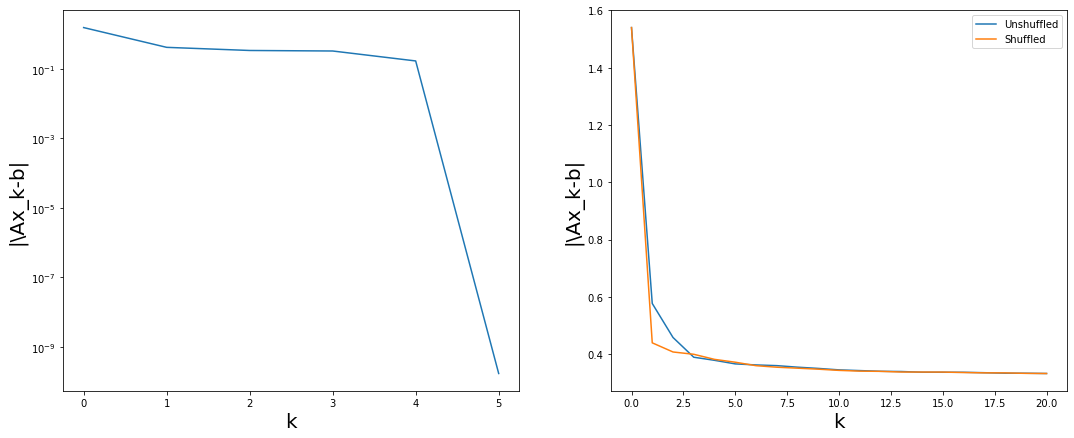

In [119]:
show_eigendescent_and_permutations()

К сожалению нахождение собственных чисел матрицы - более сложная задача, чем решение системы линейных уравнений, тем не менее алгоритмы на основе градиентного спуска, сходящиеся за конечное число шагов, существуют, но об этом чуть позже. Пока же нам инетерсно, можно ли подобрать размеры шагов зная только $m$ и $M$. Для начала отметим, что если $Ax=\lambda x$, то
$$
\begin{array}{rl}
P(A)x&=\left(\sum_{i=0}^kA^i\right)x\\
&=\sum_{i=0}^k\left(A^ix\right) \\
&=\sum_{i=0}^k\left(\lambda^ix\right)\\
&=P(\lambda)x.
\end{array}
$$
С другой стороны, так как для симметричной $A$ разным собственным числам соответствует ортогональные собственные вектора, пусть $x=\sum_{i=1}^n\beta_i\nu_i$, где $A\nu_i=\lambda_i\nu_i$, тогда
$$
\begin{array}{rl}
\|P(A)x\|^2&=\|P(A)\sum_{i=1}^n\beta_i\nu_i\|^2\\
&=\|\sum_{i=1}^nP(\lambda_i)\beta_i\nu_i\|^2 \\
&=\sum_{i=1}^n|P(\lambda_i)|^2\|\beta_i\nu_i\|^2\\
&\leq \max_{\lambda\in[m, M]}P(\lambda)x,\tag{2}
\end{array}
$$
при этом равенство достигается на собственном векторе, соответствующем максимальному собственному числу $A$.
Размер шага
$$
\alpha_k=\frac{2}{M+m}
$$
ведет к оптимальному приращению за одну итерацию и соответствует середине отрезка $[m, M]$. Тем не менее такой выбор не является оптимальным на несколько итераций, Чебышёв предложил здесь использовать многочлены, которые меньше всего отклоняются на всем отрезка $[m; M]$. 

<b>Теорема</b>. Пусть $T_n(x)$ - многочлен Чебышёва первого рода, т. е.
$$
\begin{cases}
T_0(x)&=1 \\
T_1(x)&=x \\
T_n(x)&=2xT_{n-1}(x)-T_{n-2}(x)
\end{cases}
$$
тогда среди многочленов с младшим коэффициентом $1$ степени $k$
$$
P_k(x)=\frac{T_k\left(\frac{M+m-2x}{M-m}\right)}{T_k\left(\frac{M+m}{M-m}\right)}\tag{3}
$$
имеет минимальное отклонение на отрезке $[m; M]$.
$$
\max_{x\in[m; M]}|P(x)|.
$$
<b>Доказательство.</b> Для начала отметим, что $T_k(x)\leq 1$ при $x\in[-1; 1]$ из чего следует
$$
P_k(x)\leq T_k\left(\frac{M+m}{M-m}\right)^{-1},~x\in[m;M].
$$
Не менее важным фактом является то, что экстремумы $T_k(x)$ находятся в точках
$$
x=\cos\left(\frac{\pi i}{n}\right),~i=0, \ldots, k
$$
и равняются $(-1)^i$ соовтетственно (в силу $T_k(x)=\cos(k\arccos x)$ при $x\in[-1; 1]$). Аналогично можно заключить, что и $|P_k|$ достигает экстремума в $k+1$ точке осцилируя между величинами
$$
P_k(\omega_i)=(-1)^iT_k\left(\frac{M+m}{M-m}\right)^{-1}
$$
при $\omega_i=m+(M-m)\cos\frac{\pi i}{k}$. Теперь допустим, что существует такой многочлен $Q$ степени $k$ и младшим коэффициентом $1$ такой, что
$$
|Q(x)|<|P_k(x)|,~\forall x\in[-1;1]
$$
в частности $Q(\omega_i)-P_k(\omega_i)$ больше нуля при $i+k\vdots 2$ и меньше нуля в остальных случаях. Таким образом на отрезке $[m;M]$ у многочлена $Q-P_k$ содержится $k$ корней. С другой стороны, так как у $Q$ и $P_k$ младшие коэффициенты равны $1$, то $Q(0)=P_k(0)=1$, из чего следует, что $0\notin [m;M]$ также является корнем $Q-P_k$, из чего следует, что $Q-P_k$ может быть только нулевым многочленом. $\#$

Используя корни многочлена $P_k$ в качестве величин, обратных размерам шага можно получить асимптотически оптимальное (по $k$ без учета $n$) в худшем случае приближение на $k$-ой итерации градиентного спуска. Корни $P_k$ вычисляются как
$$
\phi_i=m+(M-m)\cos\frac{\pi(2i+1)}{2k},~i=0, \ldots, k-1.
$$
Альтернативно можно поступить следующим образом: в силу $x_k=x^*+P_k(A)(x_0-x^*)$ и $P(0)=1$ получаем
$$
\begin{array}{rl}
x_k&=x^*+P_k(A)(x_0-x^*) \\
&=x^*+(I+\sum_{i=1}^k\beta_kA^i)(x_0-x^*)\\
&=x_0+\sum_{i=1}^k\beta_kA^ix_0-\sum_{i=0}^{k-1}\beta_{i+1}A^ib
\end{array}
$$
Описанные схемы обычно называют <i>полуитеративными методами Чебышёва</i> решения систем линейных уравнений. Полуитеративность обусловлена тем, что принцип работы основан на итеративной схеме градиентного спуска, но при этом в данном подходе мы заранее выбираем сколько итераций сделаем и выисляем только одно приближение. Для перехода от $k$ к $k+1$ в таком подходе потребуется полный пересчет, тем не менее рекурсивность второго порядка многочленов Чебышёва позволяет сделать этот переход более простым. Прежде, чем вывести этот переход, покажем, что скорость сходимости у метода Чебышёва лучше, чем у обычного градиентного спуска.

<b>Теорема (о скорости сходимости метода Чебышёва)</b>. Пусть $f$ - квадратичная функция, собственные числа которой зажаты в промежутке $[m; M]$ ($0<m<M$), тогда при использовании размеров шагов, заданными корнями многочлена $P_k$ из (3), для градиентного спуска выполняется следующая оценка
$$
\|x_k-x^*\|\leq \mathcal{O}\left(\left(1-\sqrt{\frac{m}{M}}\right)^k\|x_0-x^*\|\right)
$$
<b>Доказательство</b>. При $|x|\geq 1$
$$
T_k(x)=\frac{1}{2}\left(\left(x+\sqrt{x^2-1}\right)^k+\left(x-\sqrt{x^2-1}\right)^k\right)
$$
учитывая $T_k(x)\leq 1$ при $x\in[-1;1]$ получаем
$$
\begin{array}{rl}
|P_k(x)|&\leq T_k\left(\frac{M+m}{M-m}\right)^{-1} \\
&\leq 2 \left(\frac{M+m}{M-m}+\sqrt{\left(\frac{M+m}{M-m}\right)^2-1}\right)^{-k}\\
&=2 \left(\frac{M+m}{M-m}+\sqrt{\left(\frac{2\sqrt{Mm}}{M-m}\right)^2}\right)^{-k}\\
&=2 \left(\frac{(\sqrt{M}+\sqrt{m})^2}{\sqrt{M}^2-\sqrt{m}^2}\right)^{-k}\\
&=2 \left(\frac{\sqrt{M}+\sqrt{m}}{\sqrt{M}-\sqrt{m}}\right)^{-k}=2 \left(\frac{\sqrt{M}-\sqrt{m}}{\sqrt{M}+\sqrt{m}}\right)^k
\end{array}
$$
Последняя величина в этой цепочке является $\mathcal{O}\left(\left(1-\sqrt{\frac{m}{M}}\right)^k\right)$. Наконец учитывая (1) и (2) получаем утверждение теоремы. $\#$

Очевидным образом в силу $m<M$
$$
\left(1-\frac{\sqrt{m}}{\sqrt{M}}\right)<\left(1-\frac{m}{M}\right)
$$
Предположим, что мы хотим достичь точности $\epsilon$, таким образом мы получаем
$$
\left(1-\sqrt{\frac{m}{M}}\right)^k\|x_0-x^*\|\leq \epsilon
$$
$$
k\geq -\log\left(1-\sqrt{\frac{m}{M}}\right)^{-1} \log\frac{\|x_0-x^*\|}{\epsilon}\geq \sqrt{\frac{M}{m}}\log\frac{\|x_0-x^*\|}{\epsilon}
$$
Последнее неравенство опирается на $\log(1+x)\leq x$, при этом стоит иметь в виду, что $\lim_{x\rightarrow 0}\frac{\log(1+x)}{x}=1$. В обычном градиентном спуске мультипликативный фактор $\sqrt{\frac{M}{m}}$ становится $\frac{M}{m}$

In [132]:
def show_chebyshev_semiiterations():
    A = np.random.rand(5, 5)
    A = A @ A.T
    b = np.random.rand(5)
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    eig, v = np.linalg.eigh(A)
    m, M = eig[0], eig[-1]
    print(m, M)
    x = np.zeros_like(b)
    y = x
    
    iters = 5000
    
    alphas = list(reversed([(0.5 * (m + M - (M - m) * np.cos(np.pi * (2 * i + 1) / 2 / iters))) ** -1 for i in range(iters)]))
    
    errors_chebyshev = [np.linalg.norm(A @ x - b)]
    errors_best_local = [np.linalg.norm(A @ x - b)]
    
    for alpha in alphas[:len(alphas) // 2]:
        x = x - alpha * (A @ x - b)
        errors_chebyshev.append(np.linalg.norm(A @ x - b))
        
    x = y
    for alpha in alphas:
        x = x - (1 / (M)) * (A @ x - b)
        errors_best_local.append(np.linalg.norm(A @ x - b))
        
        
    axs.plot([i for i in range(len(errors_chebyshev))], errors_chebyshev, label='Chebyshev')
    axs.plot([i for i in range(len(errors_best_local))], errors_best_local, label='Basic')
    axs.legend()
    axs.set_ylabel(r'|\Ax_k-b|', fontsize=20)
    axs.set_xlabel(r'k', fontsize=20)
    axs.set_yscale('log')

0.018898270436596754 7.821841015952772


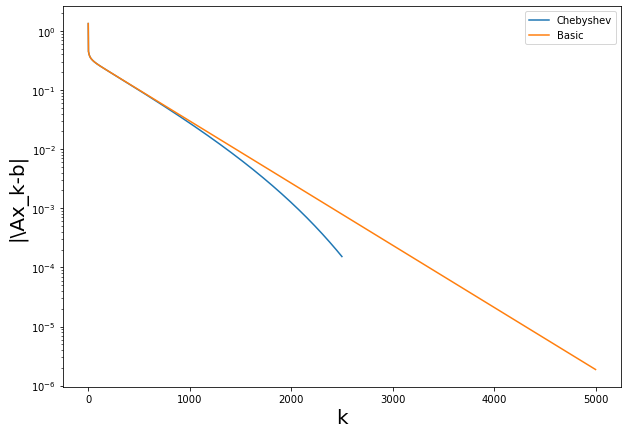

In [133]:
show_chebyshev_semiiterations()

## Итеративная реализация метода Чебышёва
Обозначим $\phi=\frac{M+m}{M-m}$, $\theta_k=T_k(\phi)$, $\gamma_k=\frac{\theta_k}{\theta_{k+1}}$, тогда
$$
\begin{array}{rl}
P_{k+1}(x)&=\frac{T_{k+1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k+1}} \\
&=\frac{2\left(\phi-\frac{2x}{M+m}\right)T_{k}\left(\phi-\frac{2x}{M+m}\right)-T_{k-1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k+1}}\\
&=\frac{2\gamma_k\left(\phi-\frac{2x}{M+m}\right)T_{k}\left(\phi-\frac{2x}{M+m}\right)}{\theta_k}-\frac{\gamma_k\gamma_{k-1}T_{k-1}\left(\phi-\frac{2x}{M+m}\right)}{\theta_{k-1}}\\
   &=2\gamma_k\left(\phi-\frac{2x}{M-m}\right)P_k(x)-\gamma_k\gamma_{k-1}P_{k-1}(x)
\end{array}
$$
Учитывая $\theta_{k+1}=2\phi\theta_k-\theta_{k-1}$ получаем
$$
P_{k+1}(x)=\left(1-\frac{4\gamma_kx}{M-m}\right)P_k(x)+\gamma_k\gamma_{k-1}(P_k(x)-P_{k-1}(x))
$$
При $x_k-x^*=P_k(A)(x_0-x^*)$, то 
$$
\begin{array}{rl}
x_{k+1}-x^*&=x_k-x^*-\frac{4\gamma_k}{M-m}A(x_k-x^*)+\gamma_k\gamma_{k-1}(x_k-x_{k-1}) \\
x_{k+1}&=x_k-\frac{4\gamma_k}{M-m}(\underbrace{Ax_k-b}_{\nabla f(x_k)})+\gamma_k\gamma_{k-1}(\underbrace{x_k-x_{k-1}}_{\mbox{момент}})
\end{array}
$$
последнее равенство позволяет без особых трудностей вычислять $x_k$ в соответствием с методом Чебышёва запоминая дополнительно $x_{k-1}$.